In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from keras.layers import Input, LSTM, RepeatVector
from keras.models import Model

In [151]:
# Cargar el dataset

filePath = "C:/Users/raul.blanco/Documents/4 - Personales/UBA/Repositorios/IA/Trabajo-Final/solar_wind.csv"
dF = pd.read_csv(filepath_or_buffer=filePath, header=0, sep=",")

df_A = dF.loc[dF['period']=='train_a']
df_A = df_A.dropna()

In [152]:
df_A.describe()

,bx_gse,by_gse,bz_gse,theta_gse,phi_gse,bx_gsm,by_gsm,bz_gsm,theta_gsm,phi_gsm,bt,density,speed,temperature
count,1.394555e+06,1.394555e+06,1.394555e+06,1.394555e+06,1.394555e+06,1.394555e+06,1.394555e+06,1.394555e+06,1.394555e+06,1.394555e+06,1.394555e+06,1.394555e+06,1.394555e+06,1.394555e+06
mean,-1.800583e+00,3.966949e-01,-1.998417e-01,-9.255569e-01,1.896923e+02,-1.800628e+00,3.517462e-01,-2.199138e-01,-1.035288e+00,1.895481e+02,7.069054e+00,4.898932e+00,4.372335e+02,1.059033e+05
std,4.293035e+00,4.768893e+00,4.339669e+00,3.461554e+01,8.778546e+01,4.293178e+00,4.730183e+00,4.384533e+00,3.509333e+01,8.793808e+01,3.693071e+00,4.834451e+00,9.460213e+01,1.001220e+05
min,-5.463000e+01,-5.169000e+01,-5.305000e+01,-8.989000e+01,0.000000e+00,-5.463000e+01,-5.268000e+01,-5.352000e+01,-8.968000e+01,0.000000e+00,1.400000e-01,0.000000e+00,2.358000e+02,1.000000e+04
25%,-4.940000e+00,-2.760000e+00,-2.660000e+00,-2.563000e+01,1.303800e+02,-4.940000e+00,-2.740000e+00,-2.700000e+00,-2.622500e+01,1.304100e+02,4.920000e+00,2.300000e+00,3.709200e+02,4.363800e+04
50%,-2.020000e+00,5.200000e-01,-1.700000e-01,-1.690000e+00,1.709000e+02,-2.020000e+00,4.600000e-01,-1.700000e-01,-1.760000e+00,1.716600e+02,6.310000e+00,3.630000e+00,4.184600e+02,7.922100e+04
75%,1.500000e+00,3.400000e+00,2.290000e+00,2.352000e+01,2.687400e+02,1.500000e+00,3.310000e+00,2.340000e+00,2.362000e+01,2.680800e+02,8.190000e+00,5.810000e+00,4.847600e+02,1.324900e+05
max,3.289000e+01,4.941000e+01,5.086000e+01,8.987000e+01,3.600000e+02,3.289000e+01,5.291000e+01,4.758000e+01,8.989000e+01,3.600000e+02,7.369000e+01,1.849300e+02,1.011500e+03,6.223700e+06


In [153]:
# Calcular el número de valores a reemplazar
#features = ['bx_gse', 'by_gse', 'bz_gse', 'theta_gse', 'phi_gse', 'bx_gsm', 'by_gsm', 'bz_gsm', 'theta_gsm', 'phi_gsm', 'bt', 'density', 'speed', 'temperature']
features = ['bt']
anomaly_factor = 0.17
# Crear una copia del DataFrame para no modificar el original
df_new = df_A.copy()

for a in features:
  num_replace = int(df_A[a].size * anomaly_factor)

  # Obtener una muestra aleatoria de índices de fila para reemplazar
  replace_idx = np.random.choice(df_A.index, size=num_replace, replace=False)

  # Reemplazar los valores seleccionados con valores aleatorios entre -90 y 1050
  #new_values = np.random.uniform(-90, 1050, size=num_replace)
  new_values = np.random.uniform(0, 75, size=num_replace)
  df_new.loc[replace_idx, a] = new_values

  # Crear la columna "class" con los valores correspondientes
  df_new.loc[df_A[a] != df_new[a], 'class'] = 1
  df_new.loc[df_A[a] == df_new[a], 'class'] = 0

In [154]:
print('En el todo el dataset:')
count = (df_new['class'] == 1).sum()
count2 = (df_new['class'] != 1).sum()
print(f'El número de anomalias es {count} de {count2} valores normales')
cociente = count / count2
print(f'La relacion de anomalias es {cociente}')

En el todo el dataset:
El número de anomalias es 237074 de 1157481 valores normales
La relacion de anomalias es 0.20481891279424888


In [155]:
# Dividir el conjunto de datos en conjuntos de entrenamiento y prueba
train_data = df_new.sample(frac=0.8, random_state=0)
test_data = df_new.drop(train_data.index)

In [156]:
train_df = pd.DataFrame(train_data, columns = ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','class'])
print('En el train set:')
count = (train_df['class'] == 1).sum()
count2 = (train_df['class'] != 1).sum()
print(f'El número de anomalias es {count} de {count2} valores normales')
cociente = count / count2
print(f'La relacion de anomalias es {cociente}')

En el train set:
El número de anomalias es 189524 de 926120 valores normales
La relacion de anomalias es 0.2046430268215782


In [157]:
test_df = pd.DataFrame(test_data, columns = ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','class'])
print('En el test:')
count = (test_df['class'] == 1).sum()
count2 = (test_df['class'] != 1).sum()
print(f'El número de anomalias es {count} de {count2} valores normales')
cociente = count / count2
print(f'La relacion de anomalias es {cociente}')


En el test:
El número de anomalias es 47550 de 231361 valores normales
La relacion de anomalias es 0.20552297059573568


In [158]:
# Preparo el dataset en X e y y elimino columnas no necesarias
y = test_data['class']
y_full = test_data
train_data = train_data.drop(["timedelta", "period", "source", 'class'], axis=1)
test_data = test_data.drop(["timedelta", "period", "source", 'class'], axis=1)

In [159]:
# Normalizar los datos utilizando StandardScaler()
scaler = StandardScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

In [160]:
train_data = train_data.reshape(train_data.shape[0],1,train_data.shape[1])
train_data.shape

(1115644, 1, 14)

In [161]:
test_data = test_data.reshape(test_data.shape[0],1,test_data.shape[1])
test_data.shape

(278911, 1, 14)

The entire network is usually trained as a whole. The loss function is usually either
the mean-squared error or cross-entropy between the output and the input, known as
the reconstruction loss, which penalizes the network for creating outputs different from
the input. Since the encoding (which is simply the output of the hidden layer in
the middle) has far less units than the input, the encoder must choose to discard
information. The encoder learns to preserve as much of the relevant information as
possible in the limited encoding and intelligently discards the irrelevant parts. The
decoder learns to take the encoding and properly reconstruct it back into the input.

In [162]:
# Crear un modelo de autoencoder con LSTM
input_dim = train_data.shape[2]
timesteps = 1

inputs = Input(shape=(timesteps, input_dim))
encoded = LSTM(64, activation='relu', return_sequences=True)(inputs)
encoded = LSTM(32, activation='relu', return_sequences=True)(inputs)
encoded = LSTM(16, activation='relu', return_sequences=False)(encoded)
decoded = RepeatVector(timesteps)(encoded)
decoded = LSTM(16, activation='relu', return_sequences=True)(decoded)
decoded = LSTM(32, activation='relu', return_sequences=True)(decoded)
decoded = LSTM(64, activation='relu', return_sequences=True)(decoded)
decoded = LSTM(input_dim, activation='linear', return_sequences=True)(decoded)

autoencoder = Model(inputs, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

In [163]:
# Entrenar el modelo utilizando los datos de entrenamiento
autoencoder.fit(train_data, train_data, epochs=10, batch_size=320, validation_split=0.1)

Epoch 1/10
3138/3138 [==============================] - 27s 7ms/step - loss: 0.1724 - val_loss: 0.0210
Epoch 2/10
3138/3138 [==============================] - 23s 7ms/step - loss: 0.0157 - val_loss: 0.0120
Epoch 3/10
3138/3138 [==============================] - 26s 8ms/step - loss: 0.0080 - val_loss: 0.0048
Epoch 4/10
3138/3138 [==============================] - 26s 8ms/step - loss: 0.0030 - val_loss: 0.0020
Epoch 5/10
3138/3138 [==============================] - 30s 10ms/step - loss: 0.0021 - val_loss: 0.0017
Epoch 6/10
3138/3138 [==============================] - 35s 11ms/step - loss: 0.0016 - val_loss: 0.0012
Epoch 7/10
3138/3138 [==============================] - 28s 9ms/step - loss: 0.0013 - val_loss: 0.0010
Epoch 8/10
3138/3138 [==============================] - 29s 9ms/step - loss: 0.0012 - val_loss: 8.7303e-04
Epoch 9/10
3138/3138 [==============================] - 28s 9ms/step - loss: 9.3647e-04 - val_loss: 8.3979e-04
Epoch 10/10
3138/3138 [==============================] - 27

In [164]:
# Utilizar el modelo para hacer predicciones en los datos de prueba
predictions = autoencoder.predict(test_data)

8716/8716 [==============================] - 17s 2ms/step


In [165]:
# Comparar las predicciones con los valores reales de "class" y generar una matriz de confusión para evaluar el modelo
threshold = 0.01
predictions[predictions >= threshold] = 1
predictions[predictions < threshold] = 0

In [166]:
predictions = predictions.reshape(predictions.shape[0], predictions.shape[2])
test_data = test_data.reshape(test_data.shape[0], test_data.shape[2])
y_full = y_full.to_numpy()
confusion_matrix = pd.crosstab(y_full[:, -1], predictions[:, 10], rownames=['Actual'], colnames=['Predicted'])
print(confusion_matrix)

Predicted     0.0    1.0
Actual                  
0.0        215500  15861
1.0          7939  39611


In [167]:
pd_predictions = pd.DataFrame(predictions)
column_10 = predictions[:, 10]
is_one = column_10 ==1
# Asignar 1 a los elementos que sean True y 0 a los elementos que sean False
has_ones = np.where(is_one, 1, 0)

In [168]:
has_ones_pd = pd.DataFrame(has_ones, columns=['class'])
count = (has_ones_pd['class'] == 1).sum()
count1 = (has_ones_pd['class'] == 0).sum()
print(f'El número de anomalias es {count} de {count1} valores normales')

El número de anomalias es 55472 de 223439 valores normales


In [169]:
new_column = has_ones
# Agregar la nueva columna al final del ndarray original
predictions_class = np.hstack((predictions, new_column.reshape(-1, 1)))

In [170]:
new_column_df = pd.DataFrame(new_column, columns =['class'])
count3 = (new_column_df['class'] == True).sum()
count4 = (new_column_df['class'] == False).sum()
print(f'El número de anomalias es {count3} de {count4} valores normales')

El número de anomalias es 55472 de 223439 valores normales


In [171]:
pd_predictions = pd.DataFrame(predictions_class)

In [172]:
pd_test_data = pd.DataFrame(test_data)

In [173]:
predictions_class[:,14]

array([1., 0., 0., ..., 0., 0., 0.])

In [174]:
from sklearn.metrics import classification_report
 
print(classification_report(predictions_class[:,14], y))

              precision    recall  f1-score   support

         0.0       0.93      0.96      0.95    223439
         1.0       0.83      0.71      0.77     55472

    accuracy                           0.91    278911
   macro avg       0.88      0.84      0.86    278911
weighted avg       0.91      0.91      0.91    278911



In [175]:
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.metrics import confusion_matrix
class visualization:
  labels = ["Normal","Anomal"]
  def draw_confusion_matrix(self, y, ypred):
    matrix = confusion_matrix(y, ypred)

    plt.figure(figsize=(10,8))
    colors=["orange", "green"]
    sns.heatmap(matrix, xticklabels=self.labels, yticklabels=self.labels, cmap=colors, annot=True, fmt="d")
    plt.title("Confusion Matrix")
    plt.ylabel("Realidad")
    plt.xlabel("Predicción")
    plt.show()

In [176]:
y_pd = pd.DataFrame(y, columns = ['class'])
count = (y_pd['class'] == 1).sum()
print(f'El número de anomalias reales es {count}')

El número de anomalias reales es 47550


In [177]:
predictions_class_pd  = pd.DataFrame(predictions_class, columns = ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','class'])
count = (predictions_class_pd['class'] == 1).sum()
print(f'El número de anomalias predecidas es {count}')

El número de anomalias predecidas es 55472


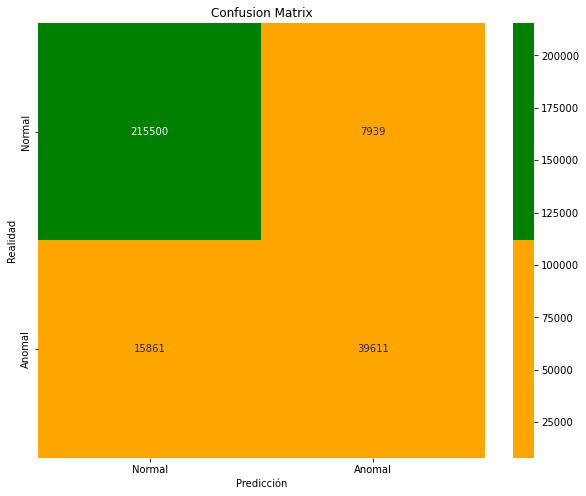

In [178]:
viz = visualization()
viz.draw_confusion_matrix(y_pd, predictions_class[:,14])